# Demonstration of Full ML Pipeline with a Materials Science Database

We will use Matminer to fetch materials datasets that are ML-ready (i.e., they largely don't require any data cleaning step). We will then consider two featurization approaches: compositional (using Matminer again) and structural (using DScribe). Then we will remove low variance features and highly correlated features with Pandas. Lastly, we use Scikit-Learn for data splitting, recursive feature elimintation, model performance metrics calculations, and ML model training (random forest model).

In [187]:
pip install requests

Note: you may need to restart the kernel to use updated packages.


### **Querying**: filter for oxygen-containing compounds. To filter for metals, I would have to manually enter every metal in an "or" list, but it is much easier to do this filtering with Pymatgen. Also, I want to filter for materials with non-zero band gaps, but the band gap filter function for the API does not work, I have tried multiple times, but it always returns nothing

In [188]:
import requests
url = "http://oqmd.org/oqmdapi/formationenergy"

all_entries = []
limit = 50  # max entries per request allowed by OQMD
offset = 0
max_entries = 10000

while len(all_entries) < max_entries:
    params = {
        "filter": "element_set=(O)",
        "limit": limit,
        "offset": offset
    }

    r = requests.get(url, params=params)
    data = r.json()

    batch = data.get("data", [])
    if not batch:
        break

    all_entries.extend(batch)
    offset += limit

    if len(all_entries) >= max_entries:
        # Stop if we have enough data
        all_entries = all_entries[:max_entries]
        break

print(f"Total entries retrieved: {len(all_entries)}")

#for entry in all_entries[:10000]:  # print entries
#    print(entry.get("name"))

#for entry in all_entries[:10]:  # print first 10 as example
#    print(entry.get("volume"), entry.get("band_gap"))

Total entries retrieved: 10000
ZnO
CuO
TiO
VO
BeO
MgO
MnO
NiO
ZnO
AgO
NiO
FeO
ZnO
AlO
NiO
CaO
PdO
SrO
SrO
PaO
BaO
TaO
O
ScO
YbO
BeO
CdO
NbO
NpO
PdO
GdO
PuO
NiO
BiO
ZrO
PtO
FeO
UO
SnO2
O
PrO
SmO
ZrO2
CrO
PdO
K2O
SrO2
Li2O
O
UO2
BaO2
Na2O
PuO2
LiO2
PaO2
Al2O
SiO2
TbO2
BaO2
Ag2O
Rb2O
HgO
CSO
KO2
RbO2
Cs2O
NpO2
PtO2
CsO2
NiO2
PbO2
CsO
NaCuO2
LiO3
AlCuO2
RbNdO2
GaCuO2
RbSmO2
FeCuO2
RbGdO2
YbAgO2
LiNiO2
PbO
NaNiO2
NaFeO2
NaCuO2
KPrO2
RbDyO2
RbHoO2
ReO3
NaNO2
RbEuO2
PtO
UO3
RbLaO2
CrCuO2
CaO
CdO
FeAgO2
CuO
MgO
SrCdO2
CuAgO2
LiCrO2
NaAlO2
CaO2
MnCuO2
CaFeO2
RbErO2
RbTmO2
RbYbO2
RbLuO2
NaCrO2
CaHgO2
NiAgO2
LiMoO2
BaHgO2
NaInO2
LiVO2
RbScO2
NaErO2
VBr2O
LuAgO2
InCuO2
AgRhO2
PbO
CaCuO2
ZnO
NiHO2
SnO
NaMnO2
CrAgO2
Sr2SO
UO3
PdO
BeO
LiAlO2
BaO
SrFeO2
LiGaO2
O
CdHgO2
BaSrO2
BaCaO2
WO3
MgO
SrCaO2
YCuO2
LiRhO2
NdNiO2
NiHO2
BaO
CuO
CsIO3
NaTaO3
NaTlO2
NaVO2
CuO2
ScBiO3
BaIrO3
KCrO2
SrVO3
LaAlO3
NdAlO3
VCl2O
Na3ClO
NaVO2
RbTlO2
NaTaO3
Li3BrO
BaPaO3
PrAlO3
KTaO3
K3BrO
CaTiO3
SrNbO3
ZrTaNO
SrCrO3
HfPbO3
B

In [221]:
# CHECK COMPOSITION TO SEE IF IT CONTAINS OXYGEN
for entry in all_entries[:100]:  # print entries
    print(entry.get("name"), entry.get("band_gap"))

ZnO 0.0
CuO 0.0
TiO 0.0
VO 1.191
BeO 7.021
MgO 4.975
MnO 0.423
NiO 2.62
ZnO 0.967
AgO 0.0
NiO 2.61
FeO 0.0
ZnO 1.084
AlO 0.0
NiO 2.611
CaO 3.687
PdO 0.0
SrO 2.792
SrO 3.363
PaO 0.0
BaO 2.111
TaO 0.0
O 0.0
ScO 0.0
YbO 3.583
BeO 8.496
CdO 0.0
NbO 0.0
NpO 0.0
PdO 0.0
GdO 0.0
PuO 0.0
NiO 2.627
BiO 0.0
ZrO 0.0
PtO 0.0
FeO 1.259
UO 0.0
SnO2 0.622999999999999
O 0.0
PrO 0.0
SmO 0.0
ZrO2 3.344
CrO 0.0
PdO 0.0
K2O 1.942
SrO2 3.152
Li2O 5.091
O 0.0
UO2 0.0
BaO2 2.349
Na2O 2.219
PuO2 0.0
LiO2 0.0
PaO2 0.0
Al2O 0.0
SiO2 2.245
TbO2 0.0
BaO2 1.994
Ag2O 0.0
Rb2O 1.637
HgO 0.0
CSO 4.762
KO2 0.0
RbO2 0.0
Cs2O 1.251
NpO2 2.612
PtO2 1.415
CsO2 0.0
NiO2 1.249
PbO2 0.0
CsO 1.902
NaCuO2 0.749
LiO3 0.0
AlCuO2 2.332
RbNdO2 3.697
GaCuO2 1.336
RbSmO2 3.774
FeCuO2 1.003
RbGdO2 3.755
YbAgO2 0.0
LiNiO2 0.0
PbO 1.276
NaNiO2 0.43
NaFeO2 1.679
NaCuO2 0.873
KPrO2 3.737
RbDyO2 3.704
RbHoO2 3.854
ReO3 0.0
NaNO2 2.453
RbEuO2 0.0
PtO 0.0
UO3 2.536
RbLaO2 3.691
CrCuO2 1.787
CaO 3.481
CdO 0.218
FeAgO2 1.089
CuO 0.0


In [ ]:
#EXPORT TO PANDAS DATAFRAME
import pandas as pd

#records = data["all_entries"]
df = pd.DataFrame(all_entries)

  name  entry_id  calculation_id   icsd_id  formationenergy_id  \
0  ZnO     20684            4500  163382.0             4061643   
1  CuO     11469            4561   61323.0             4061682   
2  TiO     17898            4752  105551.0             4061754   
3   VO      5578            5023   28681.0             4061871   
4  BeO     20737            5038  163820.0             4061895   

   duplicate_entry_id composition composition_generic prototype spacegroup  \
0            117131.0      O1 Zn1                  AB      CsCl      Pm-3m   
1             11469.0      Cu1 O1                  AB      NaCl      Fm-3m   
2             17898.0      O1 Ti1                  AB      NaCl      Fm-3m   
3              5578.0       O1 V1                  AB      NaCl      Fm-3m   
4             20737.0      Be1 O1                  AB  ZnS(cF8)      F-43m   

    volume  ntypes  natoms                                          unit_cell  \
0  18.8294       2       2  [[2.66039, 0.0, 0.0], [0.

### Use Pymatgen to further filter for metal-containing compounds and band_gap that is non-zero

In [191]:
# FILTER FOR METAL OXIDES + NON-ZERO BANDGAP
from pymatgen.core import Composition
from pymatgen.core.periodic_table import Element
import pandas as pd

def has_metal_and_oxygen(formula):
    comp = Composition(formula)

    # Must contain oxygen
    if Element("O") not in comp:
        return False

    # Check if any other element is a metal
    for el in comp.elements:
        if el.symbol != "O" and Element(el).is_metal:
            return True

    return False

# --- Apply both filters ---
df_oxides = df[
    df["composition"].apply(has_metal_and_oxygen) &
    (df["band_gap"] > 0)   # NEW: filter for non-zero band gap
].reset_index(drop=True)

print("Number of metal oxides with non-zero band gaps:", len(df_oxides))



Number of metal oxides with non-zero band gaps: 3601


### Data-cleaning: check and remove NaN bandgap entries. I checked, there are not duplicate entries

In [206]:
# --- DATA CLEANING ---

# 1. Drop rows where band_gap is NaN
df_oxides = df_oxides.dropna(subset=["band_gap"])

# Reset index after cleaning
df_oxides = df_oxides.reset_index(drop=True)

print("Cleaned dataframe size:", len(df_oxides))

Cleaned dataframe size: 2835


### Now I have a dataset of compounds that contain oxygen and 1 or more metal ions - **Metal Oxides!**

In [207]:
df_oxides.head()

,name,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,composition,composition_generic,prototype,spacegroup,volume,ntypes,natoms,unit_cell,sites,band_gap,delta_e,stability,fit,calculation_label
0,VO,5578,5023,28681.0,4061871,5578.0,O1 V1,AB,NaCl,Fm-3m,21.6233,2,2,"[[2.211215, -2.211215, 0.0], [-2.211215, 0.0, ...","[O @ 0.5 0 0.5, V @ 0 0 0]",1.191,-2.259973,0.002871,standard,static
1,BeO,20737,5038,163820.0,4061895,20737.0,Be1 O1,AB,ZnS(cF8),F-43m,13.7009,2,2,"[[1.899211, -1.899211, 0.0], [-1.899211, 0.0, ...","[Be @ 0 0 0, O @ 0.75 0.5 0.25]",7.021,-2.960379,0.005831,standard,static
2,MgO,2577,5281,9863.0,4062087,2577.0,Mg1 O1,AB,NaCl,Fm-3m,18.5095,2,2,"[[2.099529, -2.099529, 0.0], [-2.099529, 0.0, ...","[Mg @ 0 0 0, O @ 0.5 0 0.5]",4.975,-2.945943,0.000346,standard,static
3,MnO,2578,5284,9864.0,4062090,2578.0,Mn1 O1,AB,NaCl,Fm-3m,22.1982,2,2,"[[2.230638, -2.230638, 0.0], [-2.230638, 0.0, ...","[Mn @ 0 0 0, O @ 0.5 0 0.5]",0.423,-2.036127,0.002118,standard,static
4,NiO,2580,5289,9866.0,4062093,8206.0,Ni1 O1,AB,NaCl,Fm-3m,18.1016,2,2,"[[2.083992, -2.083992, 0.0], [-2.083992, 0.0, ...","[Ni @ 0 0 0, O @ 0.5 0 0.5]",2.620,-1.239372,0.002141,standard,static


In [208]:
df_oxides.describe()

,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,stability
count,2835.000000,2.835000e+03,2469.000000,2.835000e+03,2834.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000
mean,55959.944621,5.279984e+05,121850.262454,4.330324e+06,59235.855328,190.248488,3.499471,14.500529,2.786638,-2.221272,0.110539
std,113227.655473,4.549565e+05,125565.627333,2.755716e+05,120341.665443,120.215884,0.733017,10.886771,1.518161,0.747234,1.044998
min,1605.000000,5.023000e+03,7.000000,4.061871e+06,1605.000000,13.700900,2.000000,2.000000,0.183000,-4.150927,0.000000
25%,6332.000000,1.450695e+05,30283.000000,4.090164e+06,6482.250000,109.740500,3.000000,8.000000,1.596000,-2.798503,0.000000
50%,15461.000000,4.811750e+05,75254.000000,4.225941e+06,15693.000000,165.406000,3.000000,12.000000,2.651000,-2.260385,0.004057
75%,23758.500000,8.489845e+05,167053.000000,4.504952e+06,23924.000000,243.377000,4.000000,18.000000,3.826000,-1.659173,0.044370
max,675524.000000,1.234533e+06,653737.000000,4.790301e+06,675524.000000,1623.180000,7.000000,175.000000,7.769000,0.224984,54.471736


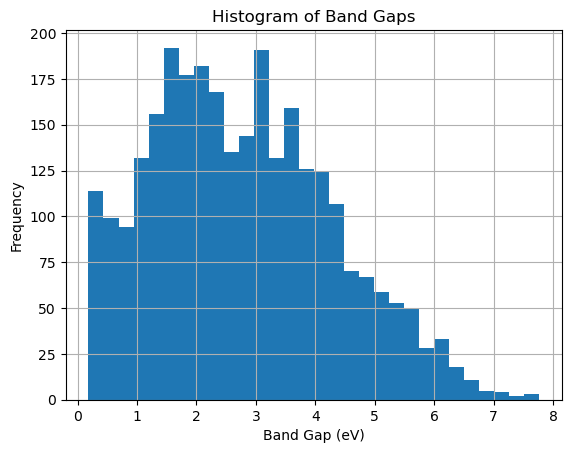

In [209]:
import matplotlib.pyplot as plt

df_oxides['band_gap'].hist(bins=30)
plt.xlabel('Band Gap (eV)')
plt.ylabel('Frequency')
plt.title('Histogram of Band Gaps')
plt.show()

In [210]:
# copy dataframe
df_comp = df_oxides.copy()
df_comp.describe()

,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,stability
count,2835.000000,2.835000e+03,2469.000000,2.835000e+03,2834.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000
mean,55959.944621,5.279984e+05,121850.262454,4.330324e+06,59235.855328,190.248488,3.499471,14.500529,2.786638,-2.221272,0.110539
std,113227.655473,4.549565e+05,125565.627333,2.755716e+05,120341.665443,120.215884,0.733017,10.886771,1.518161,0.747234,1.044998
min,1605.000000,5.023000e+03,7.000000,4.061871e+06,1605.000000,13.700900,2.000000,2.000000,0.183000,-4.150927,0.000000
25%,6332.000000,1.450695e+05,30283.000000,4.090164e+06,6482.250000,109.740500,3.000000,8.000000,1.596000,-2.798503,0.000000
50%,15461.000000,4.811750e+05,75254.000000,4.225941e+06,15693.000000,165.406000,3.000000,12.000000,2.651000,-2.260385,0.004057
75%,23758.500000,8.489845e+05,167053.000000,4.504952e+06,23924.000000,243.377000,4.000000,18.000000,3.826000,-1.659173,0.044370
max,675524.000000,1.234533e+06,653737.000000,4.790301e+06,675524.000000,1623.180000,7.000000,175.000000,7.769000,0.224984,54.471736


### **Featurization**: OQMD uses strings to identify compisition, so we must convert them to a valid pymatgen composition. Then we weill featurize the compositions using the Matminer *ElementProperty* featurizer and use the magpie preset.

In [214]:
from pymatgen.core import Composition

df_comp["composition"] = df_comp["composition"].apply(Composition)

In [215]:
from matminer.featurizers.composition.composite import ElementProperty

el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie', impute_nan=False)
el_prop_featuriser.set_n_jobs(1)
df_featurized = el_prop_featuriser.featurize_dataframe(df_comp, col_id='composition', ignore_errors=True) #SET IGNORE_ERRORS=TRUE, THIS MAY BE A MISTAKE

print(df_featurized.shape)  # type: ignore
print(df_featurized.isnull().sum().sum())  # Check for any NaN values  # type: ignore
#df_featurized.head()  # type: ignore
df_featurized.describe()  # type: ignore

/Users/coenradttaylor/opt/anaconda3/envs/chme6320/lib/python3.11/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


ElementProperty:   0%|          | 0/2835 [00:00<?, ?it/s]

(2835, 152)
1067


,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
count,2835.000000,2.835000e+03,2469.000000,2.835000e+03,2834.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,...,2835.000000,2835.000000,2835.000000,2835.0,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000
mean,55959.944621,5.279984e+05,121850.262454,4.330324e+06,59235.855328,190.248488,3.499471,14.500529,2.786638,-2.221272,...,0.133115,0.022514,0.035371,0.0,11.318871,217.578131,206.259259,93.468572,85.429397,27.248325
std,113227.655473,4.549565e+05,125565.627333,2.755716e+05,120341.665443,120.215884,0.733017,10.886771,1.518161,0.747234,...,0.475745,0.091578,0.137021,0.0,2.506571,23.517073,23.620981,27.823295,17.623874,52.050032
min,1605.000000,5.023000e+03,7.000000,4.061871e+06,1605.000000,13.700900,2.000000,2.000000,0.183000,-4.150927,...,0.000000,0.000000,0.000000,0.0,2.000000,12.000000,0.000000,11.600000,0.000000,2.000000
25%,6332.000000,1.450695e+05,30283.000000,4.090164e+06,6482.250000,109.740500,3.000000,8.000000,1.596000,-2.798503,...,0.000000,0.000000,0.000000,0.0,12.000000,217.000000,205.000000,78.500000,78.080000,12.000000
50%,15461.000000,4.811750e+05,75254.000000,4.225941e+06,15693.000000,165.406000,3.000000,12.000000,2.651000,-2.260385,...,0.000000,0.000000,0.000000,0.0,12.000000,229.000000,217.000000,91.800000,89.040000,12.000000
75%,23758.500000,8.489845e+05,167053.000000,4.504952e+06,23924.000000,243.377000,4.000000,18.000000,3.826000,-1.659173,...,0.000000,0.000000,0.000000,0.0,12.000000,229.000000,217.000000,110.721154,98.024691,12.000000
max,675524.000000,1.234533e+06,653737.000000,4.790301e+06,675524.000000,1623.180000,7.000000,175.000000,7.769000,0.224984,...,2.110663,1.055331,1.055331,0.0,12.000000,229.000000,227.000000,201.333333,109.551020,229.000000


Number of features before cleaning: 150
Columns with very small variance: ['MagpieData maximum NsValence', 'MagpieData minimum NdValence', 'MagpieData minimum NfValence', 'MagpieData minimum NsUnfilled', 'MagpieData minimum NdUnfilled', 'MagpieData mode NdUnfilled', 'MagpieData minimum NfUnfilled', 'MagpieData minimum GSbandgap', 'MagpieData minimum GSmagmom', 'MagpieData mode GSmagmom']
Number of features after removing small variance columns: 132
Columns to drop due to high correlation: {'MagpieData range Column', 'MagpieData maximum NdValence', 'MagpieData range NdValence', 'MagpieData mean GSmagmom', 'MagpieData range NfUnfilled', 'MagpieData avg_dev Number', 'MagpieData range GSbandgap', 'MagpieData maximum NpValence', 'MagpieData range SpaceGroupNumber', 'MagpieData range NsUnfilled', 'MagpieData mean NdUnfilled', 'MagpieData mode Number', 'MagpieData range GSmagmom', 'MagpieData minimum AtomicWeight', 'MagpieData avg_dev NfUnfilled', 'MagpieData range NUnfilled', 'MagpieData max

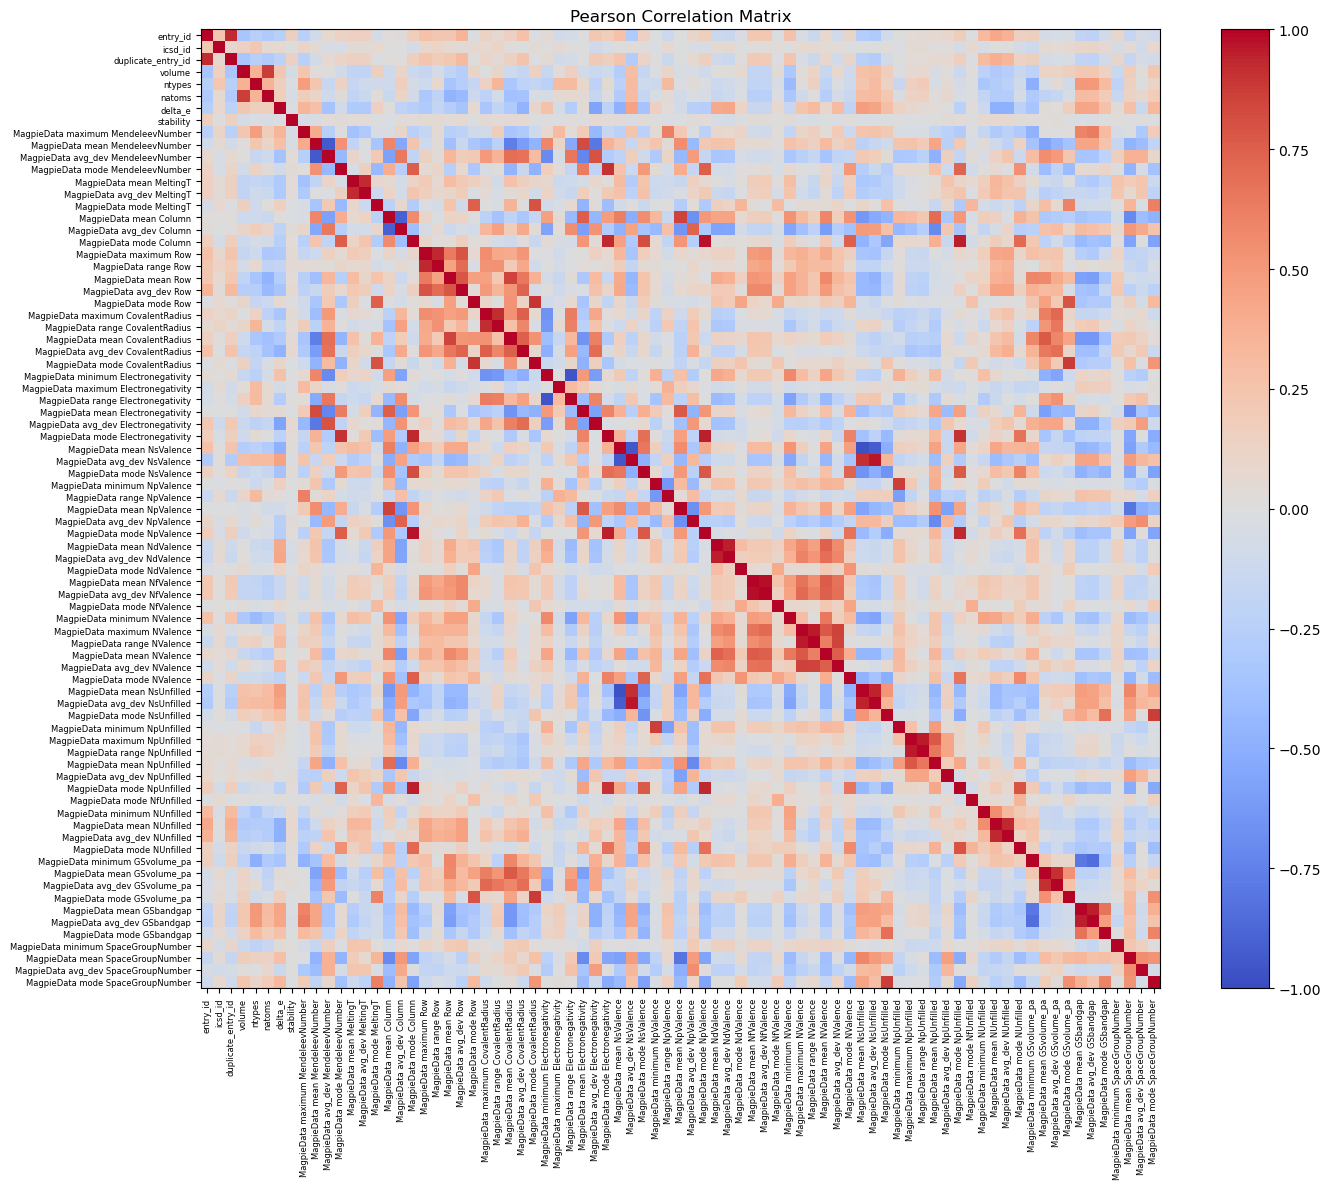

In [216]:
y = df_featurized['band_gap']  # type: ignore
X_all = df_featurized.drop(columns=['band_gap', 'composition']) # type: ignore

print("Number of features before cleaning:", X_all.shape[1])

# Keep ONLY numeric columns
X_all = X_all.select_dtypes(include=['number'])

# Identify columns with very small variance and drop them
small_var_cols = X_all.columns[X_all.var() < 1e-5].tolist()
print("Columns with very small variance:", small_var_cols)
X_all = X_all.drop(columns=small_var_cols)
corr_matrix = X_all.corr(method='pearson')
print("Number of features after removing small variance columns:", X_all.shape[1])

# Remove highly correlated columns
threshold = 0.98 #SET IT TO 0.98, COULD SWITCH IT BACK TO 0.99 IF NEEDED
to_drop = set()
for col in corr_matrix.columns:
    high_corr = corr_matrix.index[(corr_matrix[col].abs() > threshold) & (corr_matrix.index != col)]
    to_drop.update(high_corr)
print("Columns to drop due to high correlation:", to_drop)
X = X_all.drop(columns=list(to_drop))
print("Number of features after removing highly correlated columns:", X.shape[1])

# For the remaining features, let's visualize the correlation matrix
corr_matrix = X.corr(method='pearson')

plt.figure(figsize=(16, 12))
im = plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Pearson Correlation Matrix')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns, fontsize=6)
plt.tight_layout()
plt.show()

### scale and split train/test

In [217]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, 
                                                          test_size=test_fraction, 
                                                          random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=17)
print(f"Training fraction: {X_train.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X_scaled.shape[0]:.2f}")



Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10


### Dummy model for baseline prediction

In [218]:
from sklearn.metrics import mean_absolute_error

mean_train = y_train.mean()
baseline_mae = mean_absolute_error(y_val, [mean_train] * len(y_val))
print(f"Baseline MAE (predicting band gap): {baseline_mae:.4f} eV")

Baseline MAE (predicting band gap): 1.3041 eV


### **Hyperparameter optimization** Picking three values each for n_estimators, max_depth, max_features, min_samples_split, and min_sample_leaf, for a total of 243 models. Will select best combination of hyperparameters

In [219]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from itertools import product
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# SELECTION OF HYPERPARAMETERS - 3 values each, added min_samples_leaf
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20],
    "max_features": ["sqrt", 0.5, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Generate all combinations (now 3*3*3*3*3 = 243 combinations)
param_combinations = list(product(
    param_grid["n_estimators"],
    param_grid["max_depth"],
    param_grid["max_features"],
    param_grid["min_samples_split"],
    param_grid["min_samples_leaf"]
))

results = []

# Train each model
for (n_est, depth, max_feat, min_split, min_leaf) in tqdm(param_combinations, desc=f"Training {len(param_combinations)} RF models"):
    
    rf = RandomForestRegressor(
        n_estimators=n_est,
        max_depth=depth,
        max_features=max_feat,
        min_samples_split=min_split,
        min_samples_leaf=min_leaf,
        random_state=17,
        n_jobs=-1
    )
    
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    results.append({
        "n_estimators": n_est,
        "max_depth": depth,
        "max_features": max_feat,
        "min_samples_split": min_split,
        "min_samples_leaf": min_leaf,
        "train_mae": train_mae,
        "val_mae": val_mae
    })

results_df = pd.DataFrame(results)

# Pick lowest validation MAE
best_row = results_df.loc[results_df["val_mae"].idxmin()]
print("Best Hyperparameters:")
print(best_row)

print("\nBest Validation MAE:", best_row["val_mae"])

# Show full table sorted by validation performance
display(results_df.sort_values("val_mae"))


Training 243 RF models:   0%|          | 0/243 [00:00<?, ?it/s]

Best Hyperparameters:
n_estimators              500
max_depth                20.0
max_features              0.5
min_samples_split           2
min_samples_leaf            1
train_mae            0.209979
val_mae              0.542003
Name: 225, dtype: object

Best Validation MAE: 0.5420029974701938


,n_estimators,max_depth,max_features,min_samples_split,min_samples_leaf,train_mae,val_mae
225,500,20.0,0.5,2,1,0.209979,0.542003
147,300,20.0,0.5,5,1,0.236659,0.542019
171,500,NaN,0.5,2,1,0.210185,0.542365
172,500,NaN,0.5,2,2,0.241927,0.542629
228,500,20.0,0.5,5,1,0.235776,0.542995
...,...,...,...,...,...,...,...
113,300,10.0,sqrt,5,4,0.479285,0.631648
33,100,10.0,sqrt,10,1,0.464706,0.632024
197,500,10.0,sqrt,10,4,0.488101,0.632656
35,100,10.0,sqrt,10,4,0.492676,0.633075


### **Recursive feature elimination**

RFE Progress:   0%|          | 0/15 [00:00<?, ?it/s]

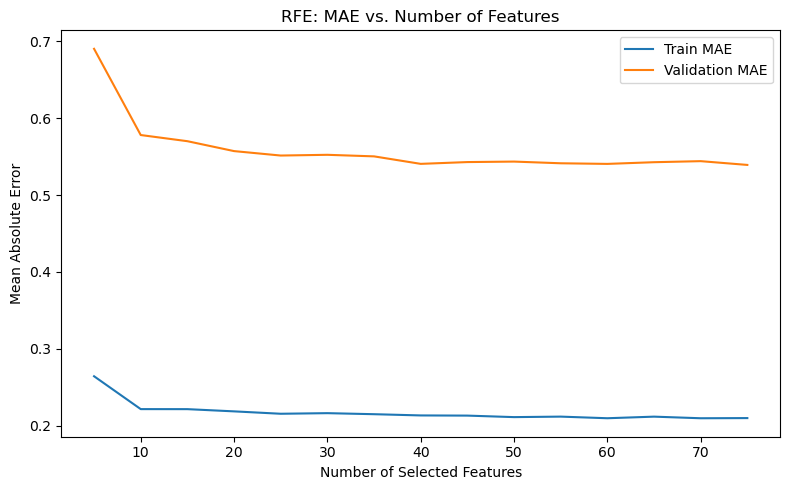

In [220]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm

rf = RandomForestRegressor(n_estimators=500, max_depth=20, max_features=0.5, min_samples_split=2, min_samples_leaf=1, random_state=17, n_jobs=1)
n_features_list = list(range(5, X_val.shape[1]+1, 5))
val_errors = []
train_errors = []
selected_features_dict = {}

for n_features in tqdm(n_features_list, desc='RFE Progress'):
    rfe = RFE(estimator=rf, n_features_to_select=n_features, step=5)
    rfe.fit(X_train, y_train)
    selected_features_dict[n_features] = list(X.columns[rfe.support_])
    X_train_rfe = rfe.transform(X_train)
    rf.fit(X_train_rfe, y_train)
    y_train_pred = rf.predict(X_train_rfe)
    train_errors.append(mean_absolute_error(y_train, y_train_pred))
    X_val_rfe = rfe.transform(X_val)
    y_val_pred = rf.predict(X_val_rfe)
    val_errors.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_features_list, train_errors, label='Train MAE')
plt.plot(n_features_list, val_errors, label='Validation MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Absolute Error')
plt.title('RFE: MAE vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()

### **Final model evalutation**: only need ~15 features to relatively minimize MAE, but 40 features shows best MAE values

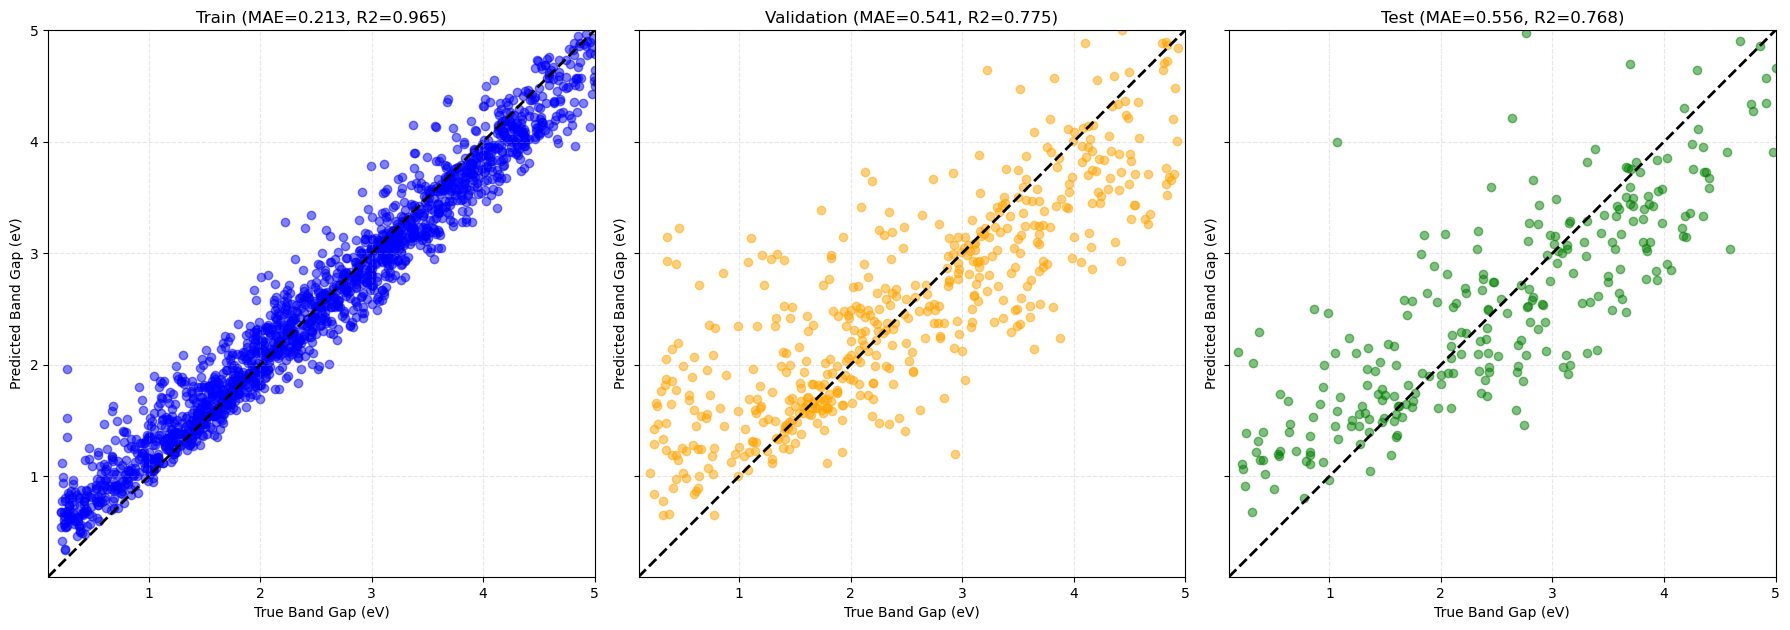

In [225]:
from sklearn.metrics import r2_score

final_features = selected_features_dict[40]
rf_final = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    max_features=0.5,
    min_samples_split=2,
    random_state=17,
    n_jobs=1
    #min_samples_leaf default is 1 already
)

X_train_final = X_train[:, [X.columns.get_loc(f) for f in final_features]]
rf_final.fit(X_train_final, y_train)

# Predict
X_val_final = X_val[:, [X.columns.get_loc(f) for f in final_features]]
X_test_final = X_test[:, [X.columns.get_loc(f) for f in final_features]]

y_train_pred = rf_final.predict(X_train_final)
y_val_pred = rf_final.predict(X_val_final)
y_test_pred = rf_final.predict(X_test_final)

# Metrics
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val = mean_absolute_error(y_val, y_val_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)
r2_test = r2_score(y_test, y_test_pred)

# --- Parity plots (0.1 to 5 range) ---
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

min_val = 0.1
max_val = 5.0

# Train
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[0].set_xlim(min_val, max_val)
axes[0].set_ylim(min_val, max_val)
axes[0].set_title(f"Train (MAE={mae_train:.3f}, R2={r2_train:.3f})")
axes[0].set_xlabel("True Band Gap (eV)")
axes[0].set_ylabel("Predicted Band Gap (eV)")
axes[0].set_aspect('equal', adjustable='box')
axes[0].grid(True, linestyle='--', alpha=0.3)

# Validation
axes[1].scatter(y_val, y_val_pred, alpha=0.5, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[1].set_xlim(min_val, max_val)
axes[1].set_ylim(min_val, max_val)
axes[1].set_title(f"Validation (MAE={mae_val:.3f}, R2={r2_val:.3f})")
axes[1].set_xlabel("True Band Gap (eV)")
axes[1].set_ylabel("Predicted Band Gap (eV)")
axes[1].set_aspect('equal', adjustable='box')
axes[1].grid(True, linestyle='--', alpha=0.3)

# Test
axes[2].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[2].set_xlim(min_val, max_val)
axes[2].set_ylim(min_val, max_val)
axes[2].set_title(f"Test (MAE={mae_test:.3f}, R2={r2_test:.3f})")
axes[2].set_xlabel("True Band Gap (eV)")
axes[2].set_ylabel("Predicted Band Gap (eV)")
axes[2].set_aspect('equal', adjustable='box')
axes[2].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


# Attempt 2: Different featurizer

In [226]:
from dscribe.descriptors import CoulombMatrix
from ase.build import molecule
from ase.visualize import view
from dscribe.descriptors import EwaldSumMatrix
from pymatgen.io.ase import AseAtomsAdaptor

In [227]:
df_comp1 = df_oxides.copy()
df_comp1.head()

,name,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,composition,composition_generic,prototype,spacegroup,volume,ntypes,natoms,unit_cell,sites,band_gap,delta_e,stability,fit,calculation_label
0,VO,5578,5023,28681.0,4061871,5578.0,O1 V1,AB,NaCl,Fm-3m,21.6233,2,2,"[[2.211215, -2.211215, 0.0], [-2.211215, 0.0, ...","[O @ 0.5 0 0.5, V @ 0 0 0]",1.191,-2.259973,0.002871,standard,static
1,BeO,20737,5038,163820.0,4061895,20737.0,Be1 O1,AB,ZnS(cF8),F-43m,13.7009,2,2,"[[1.899211, -1.899211, 0.0], [-1.899211, 0.0, ...","[Be @ 0 0 0, O @ 0.75 0.5 0.25]",7.021,-2.960379,0.005831,standard,static
2,MgO,2577,5281,9863.0,4062087,2577.0,Mg1 O1,AB,NaCl,Fm-3m,18.5095,2,2,"[[2.099529, -2.099529, 0.0], [-2.099529, 0.0, ...","[Mg @ 0 0 0, O @ 0.5 0 0.5]",4.975,-2.945943,0.000346,standard,static
3,MnO,2578,5284,9864.0,4062090,2578.0,Mn1 O1,AB,NaCl,Fm-3m,22.1982,2,2,"[[2.230638, -2.230638, 0.0], [-2.230638, 0.0, ...","[Mn @ 0 0 0, O @ 0.5 0 0.5]",0.423,-2.036127,0.002118,standard,static
4,NiO,2580,5289,9866.0,4062093,8206.0,Ni1 O1,AB,NaCl,Fm-3m,18.1016,2,2,"[[2.083992, -2.083992, 0.0], [-2.083992, 0.0, ...","[Ni @ 0 0 0, O @ 0.5 0 0.5]",2.620,-1.239372,0.002141,standard,static


In [228]:
df_comp1.describe()

,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,stability
count,2835.000000,2.835000e+03,2469.000000,2.835000e+03,2834.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000
mean,55959.944621,5.279984e+05,121850.262454,4.330324e+06,59235.855328,190.248488,3.499471,14.500529,2.786638,-2.221272,0.110539
std,113227.655473,4.549565e+05,125565.627333,2.755716e+05,120341.665443,120.215884,0.733017,10.886771,1.518161,0.747234,1.044998
min,1605.000000,5.023000e+03,7.000000,4.061871e+06,1605.000000,13.700900,2.000000,2.000000,0.183000,-4.150927,0.000000
25%,6332.000000,1.450695e+05,30283.000000,4.090164e+06,6482.250000,109.740500,3.000000,8.000000,1.596000,-2.798503,0.000000
50%,15461.000000,4.811750e+05,75254.000000,4.225941e+06,15693.000000,165.406000,3.000000,12.000000,2.651000,-2.260385,0.004057
75%,23758.500000,8.489845e+05,167053.000000,4.504952e+06,23924.000000,243.377000,4.000000,18.000000,3.826000,-1.659173,0.044370
max,675524.000000,1.234533e+06,653737.000000,4.790301e+06,675524.000000,1623.180000,7.000000,175.000000,7.769000,0.224984,54.471736


### **Structural featurization**: OQMD does not have a 'structure' column like materials project, but it does have 'unit_cell' and 'sites'. From this, we can use Pymatgen to contruct a structure

In [229]:
from pymatgen.core import Lattice, Structure

def parse_site(site_str):
    # Example input: "O @ 0.5 0.5 0.5"
    element, _, coords_str = site_str.partition(" @ ")
    coords = list(map(float, coords_str.split()))
    return element, coords

def create_structure(row):
    lattice = Lattice(row['unit_cell'])
    
    species = []
    coords = []
    
    for site_str in row['sites']:
        el, crd = parse_site(site_str)
        species.append(el)
        coords.append(crd)
    
    struct = Structure(lattice, species, coords)  # coords are fractional by default
    return struct

# Apply to your dataframe
df_comp1['structure'] = df_comp1.apply(create_structure, axis=1)

# Then make a copy with all existing columns + 'structure'
df_structure = df_comp1.copy()

df_structure.head()

,name,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,composition,composition_generic,prototype,spacegroup,...,ntypes,natoms,unit_cell,sites,band_gap,delta_e,stability,fit,calculation_label,structure
0,VO,5578,5023,28681.0,4061871,5578.0,O1 V1,AB,NaCl,Fm-3m,...,2,2,"[[2.211215, -2.211215, 0.0], [-2.211215, 0.0, ...","[O @ 0.5 0 0.5, V @ 0 0 0]",1.191,-2.259973,0.002871,standard,static,"[[2.211215 0. 0. ] O, [0. 0. 0.] V]"
1,BeO,20737,5038,163820.0,4061895,20737.0,Be1 O1,AB,ZnS(cF8),F-43m,...,2,2,"[[1.899211, -1.899211, 0.0], [-1.899211, 0.0, ...","[Be @ 0 0 0, O @ 0.75 0.5 0.25]",7.021,-2.960379,0.005831,standard,static,"[[0. 0. 0.] Be, [ 0.9496055 -0.9496055 -0.9496..."
2,MgO,2577,5281,9863.0,4062087,2577.0,Mg1 O1,AB,NaCl,Fm-3m,...,2,2,"[[2.099529, -2.099529, 0.0], [-2.099529, 0.0, ...","[Mg @ 0 0 0, O @ 0.5 0 0.5]",4.975,-2.945943,0.000346,standard,static,"[[0. 0. 0.] Mg, [2.099529 0. 0. ] O]"
3,MnO,2578,5284,9864.0,4062090,2578.0,Mn1 O1,AB,NaCl,Fm-3m,...,2,2,"[[2.230638, -2.230638, 0.0], [-2.230638, 0.0, ...","[Mn @ 0 0 0, O @ 0.5 0 0.5]",0.423,-2.036127,0.002118,standard,static,"[[0. 0. 0.] Mn, [2.230638 0. 0. ] O]"
4,NiO,2580,5289,9866.0,4062093,8206.0,Ni1 O1,AB,NaCl,Fm-3m,...,2,2,"[[2.083992, -2.083992, 0.0], [-2.083992, 0.0, ...","[Ni @ 0 0 0, O @ 0.5 0 0.5]",2.620,-1.239372,0.002141,standard,static,"[[0. 0. 0.] Ni, [2.083992 0. 0. ] O]"


In [230]:
df_structure.describe()

,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,volume,ntypes,natoms,band_gap,delta_e,stability
count,2835.000000,2.835000e+03,2469.000000,2.835000e+03,2834.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000,2835.000000
mean,55959.944621,5.279984e+05,121850.262454,4.330324e+06,59235.855328,190.248488,3.499471,14.500529,2.786638,-2.221272,0.110539
std,113227.655473,4.549565e+05,125565.627333,2.755716e+05,120341.665443,120.215884,0.733017,10.886771,1.518161,0.747234,1.044998
min,1605.000000,5.023000e+03,7.000000,4.061871e+06,1605.000000,13.700900,2.000000,2.000000,0.183000,-4.150927,0.000000
25%,6332.000000,1.450695e+05,30283.000000,4.090164e+06,6482.250000,109.740500,3.000000,8.000000,1.596000,-2.798503,0.000000
50%,15461.000000,4.811750e+05,75254.000000,4.225941e+06,15693.000000,165.406000,3.000000,12.000000,2.651000,-2.260385,0.004057
75%,23758.500000,8.489845e+05,167053.000000,4.504952e+06,23924.000000,243.377000,4.000000,18.000000,3.826000,-1.659173,0.044370
max,675524.000000,1.234533e+06,653737.000000,4.790301e+06,675524.000000,1623.180000,7.000000,175.000000,7.769000,0.224984,54.471736


### Featurize using Ewald Sum Matrix

In [231]:
from dscribe.descriptors import EwaldSumMatrix
from pymatgen.io.ase import AseAtomsAdaptor
import numpy as np

# Determine the maximum number of atoms across all structures in the dataset
n_max = 0
for mat in df_structure['structure']:
    if len(mat) > n_max :
        n_max = len(mat)
print(n_max)

ews = EwaldSumMatrix(n_atoms_max=n_max, permutation="eigenspectrum")

ase_structures = [AseAtomsAdaptor.get_atoms(struc) for struc in df_structure['structure']]
ews_matrices = np.array(ews.create(ase_structures))

175


In [234]:
ews_columns = [f'ews_{i}' for i in range(ews_matrices.shape[1])]
df_featurized_ews = df_structure.copy() #NEED TO COPY DF_STRUCTURE TO AVOID OVERWRITING
df_featurized_ews[ews_columns] = pd.DataFrame(ews_matrices, index=df_featurized_ews.index)
df_featurized_ews.head()

/var/folders/qm/5sjb9c6x42qfnfbqt3vs1x6m0000gn/T/ipykernel_1122/3198656235.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featurized_ews[ews_columns] = pd.DataFrame(ews_matrices, index=df_featurized_ews.index)
/var/folders/qm/5sjb9c6x42qfnfbqt3vs1x6m0000gn/T/ipykernel_1122/3198656235.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_featurized_ews[ews_columns] = pd.DataFrame(ews_matrices, index=df_featurized_ews.index)
/var/folders/qm/5sjb9c6x42qfnfbqt3vs1x6m0000gn/T/ipykernel_1122/3198656235.py:3: PerformanceWarnin

,name,entry_id,calculation_id,icsd_id,formationenergy_id,duplicate_entry_id,composition,composition_generic,prototype,spacegroup,...,ews_165,ews_166,ews_167,ews_168,ews_169,ews_170,ews_171,ews_172,ews_173,ews_174
0,VO,5578,5023,28681.0,4061871,5578.0,O1 V1,AB,NaCl,Fm-3m,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BeO,20737,5038,163820.0,4061895,20737.0,Be1 O1,AB,ZnS(cF8),F-43m,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,MgO,2577,5281,9863.0,4062087,2577.0,Mg1 O1,AB,NaCl,Fm-3m,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,MnO,2578,5284,9864.0,4062090,2578.0,Mn1 O1,AB,NaCl,Fm-3m,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NiO,2580,5289,9866.0,4062093,8206.0,Ni1 O1,AB,NaCl,Fm-3m,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Number of numeric features before cleaning: 185
Columns with very small variance: []
Number of features after removing small variance columns: 185
Columns to drop due to high correlation: {'ews_172', 'ews_85', 'ews_115', 'ews_119', 'ews_152', 'ews_154', 'ews_105', 'ews_111', 'ews_82', 'ews_126', 'ews_107', 'ews_151', 'ews_153', 'ews_95', 'ews_117', 'ews_87', 'ews_94', 'ews_103', 'ews_139', 'ews_170', 'ews_101', 'ews_112', 'ews_131', 'ews_159', 'ews_97', 'ews_100', 'ews_109', 'ews_162', 'ews_116', 'ews_92', 'ews_155', 'ews_102', 'ews_90', 'ews_108', 'ews_86', 'ews_174', 'ews_83', 'ews_99', 'ews_165', 'ews_96', 'ews_156', 'ews_148', 'ews_91', 'ews_128', 'ews_140', 'ews_147', 'ews_173', 'ews_113', 'ews_136', 'ews_84', 'ews_127', 'ews_110', 'ews_163', 'ews_89', 'ews_123', 'ews_138', 'ews_171', 'ews_168', 'ews_120', 'ews_124', 'ews_88', 'ews_142', 'ews_77', 'ews_125', 'ews_134', 'ews_114', 'ews_93', 'ews_78', 'ews_80', 'ews_118', 'ews_135', 'ews_130', 'ews_144', 'ews_167', 'ews_106', 'ews_1

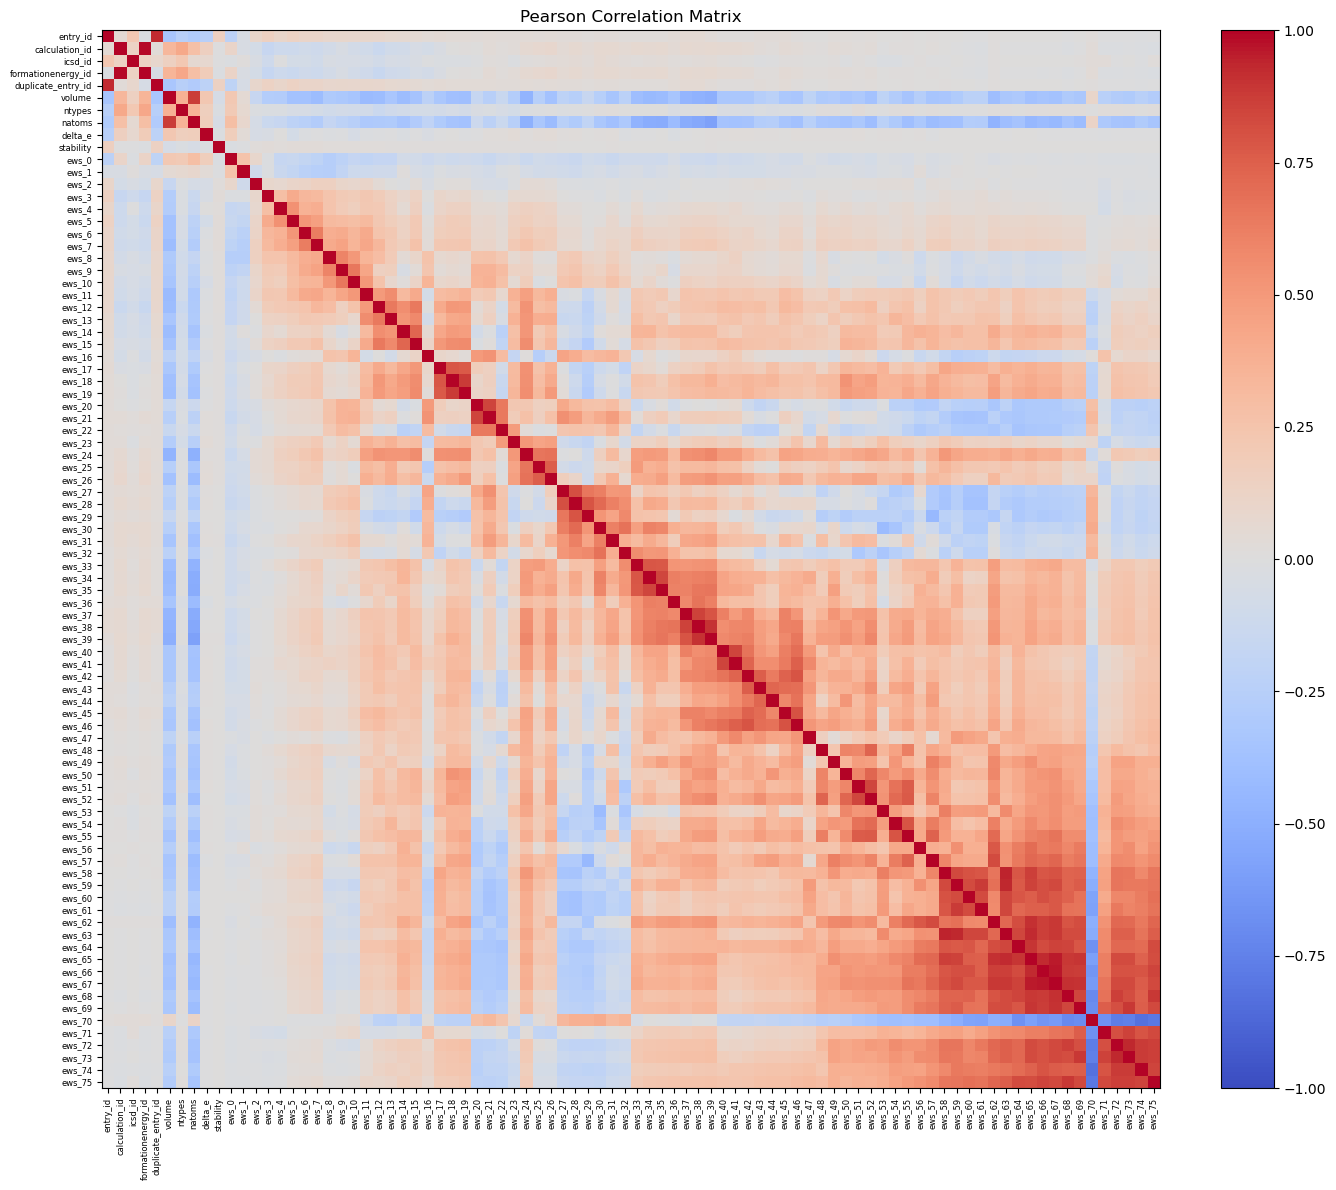

In [235]:
import matplotlib.pyplot as plt

y = df_featurized_ews['band_gap']
X_all_struc = df_featurized_ews.drop(columns=['band_gap', 'structure'])

# Keep only numeric columns
X_all_struc = X_all_struc.select_dtypes(include=[float, int])
print("Number of numeric features before cleaning:", X_all_struc.shape[1])

# Identify columns with very small variance and drop them
small_var_cols_struc = X_all_struc.columns[X_all_struc.var() < 1e-5].tolist()
print("Columns with very small variance:", small_var_cols_struc)
X_all_struc = X_all_struc.drop(columns=small_var_cols_struc)

# Compute correlation matrix
corr_matrix_struc = X_all_struc.corr(method='pearson')
print("Number of features after removing small variance columns:", X_all_struc.shape[1])

# Remove highly correlated columns
threshold = 0.99 
to_drop_struc = set()
for col in corr_matrix_struc.columns:
    high_corr_struc = corr_matrix_struc.index[
        (corr_matrix_struc[col].abs() > threshold) & (corr_matrix_struc.index != col)
    ]
    to_drop_struc.update(high_corr_struc)
print("Columns to drop due to high correlation:", to_drop_struc)
X_struc = X_all_struc.drop(columns=list(to_drop_struc))
print("Number of features after removing highly correlated columns:", X_struc.shape[1])

# Plot correlation matrix
corr_matrix_struc = X_struc.corr(method='pearson')
plt.figure(figsize=(16, 12))
im = plt.imshow(corr_matrix_struc, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.title('Pearson Correlation Matrix')
plt.xticks(range(len(corr_matrix_struc.columns)), [str(c) for c in corr_matrix_struc.columns], rotation=90, fontsize=6)
plt.yticks(range(len(corr_matrix_struc.columns)), [str(c) for c in corr_matrix_struc.columns], fontsize=6)
plt.tight_layout()
plt.show()


In [236]:
# SPLIT INTO TRAIN VALIDATION AND TEST
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_struc)

test_fraction = 0.1
validation_fraction = 0.2
X_trainval, X_test, y_trainval, y_test = train_test_split(X_scaled, y, 
                                                          test_size=test_fraction, 
                                                          random_state=17)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, 
                                                  test_size=validation_fraction/(1-test_fraction), 
                                                  random_state=17)
print(f"Training fraction: {X_train.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Validation fraction: {X_val.shape[0] / X_scaled.shape[0]:.2f}")
print(f"Test fraction: {X_test.shape[0] / X_scaled.shape[0]:.2f}")

Training fraction: 0.70
Validation fraction: 0.20
Test fraction: 0.10


In [237]:
from sklearn.metrics import mean_absolute_error

mean_train = y_train.mean()
baseline_mae = mean_absolute_error(y_val, [mean_train] * len(y_val))
print(f"Baseline MAE (predicting density): {baseline_mae:.4f} ")

Baseline MAE (predicting density): 1.3041 


### Redo hyperparameter optimization for new featurized dataset

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from itertools import product
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# SELECTION OF HYPERPARAMETERS
param_grid = {
    "n_estimators": [100, 500],
    "max_depth": [None, 20],
    "max_features": ["sqrt", 0.5],
    "min_samples_split": [2, 10],
}

# Generate all combinations
param_combinations = list(product(
    param_grid["n_estimators"],
    param_grid["max_depth"],
    param_grid["max_features"],
    param_grid["min_samples_split"]
))
results = []

#Train each model
for (n_est, depth, max_feat, min_split) in tqdm(param_combinations, desc="Training 16 RF models"):
    
    rf = RandomForestRegressor(
        n_estimators=n_est,
        max_depth=depth,
        max_features=max_feat,
        min_samples_split=min_split,
        random_state=17,
        n_jobs=-1
    )
    
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    results.append({
        "n_estimators": n_est,
        "max_depth": depth,
        "max_features": max_feat,
        "min_samples_split": min_split,
        "train_mae": train_mae,
        "val_mae": val_mae
    })

import pandas as pd
results_df = pd.DataFrame(results)

#pick lowest MAE
best_row = results_df.loc[results_df["val_mae"].idxmin()]
print("Best Hyperparameters:")
print(best_row)

print("\nBest Validation MAE:", best_row["val_mae"])

# Show full table sorted by validation performance
display(results_df.sort_values("val_mae"))


Training 16 RF models:   0%|          | 0/16 [00:00<?, ?it/s]

Best Hyperparameters:
n_estimators              500
max_depth                20.0
max_features              0.5
min_samples_split           2
train_mae            0.296207
val_mae              0.760134
Name: 14, dtype: object

Best Validation MAE: 0.7601339086090504


,n_estimators,max_depth,max_features,min_samples_split,train_mae,val_mae
14,500,20.0,0.5,2,0.296207,0.760134
10,500,NaN,0.5,2,0.297213,0.763168
6,100,20.0,0.5,2,0.307822,0.768392
2,100,NaN,0.5,2,0.309203,0.769920
8,500,NaN,sqrt,2,0.320039,0.799771
4,100,20.0,sqrt,2,0.324860,0.800661
15,500,20.0,0.5,10,0.461418,0.804976
11,500,NaN,0.5,10,0.461689,0.805227
12,500,20.0,sqrt,2,0.326472,0.805712
0,100,NaN,sqrt,2,0.324357,0.806151


### below is just copy and pasted code from above

In [238]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from itertools import product
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# SELECTION OF HYPERPARAMETERS - 3 values each, added min_samples_leaf
param_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20],
    "max_features": ["sqrt", 0.5, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Generate all combinations (now 3*3*3*3*3 = 243 combinations)
param_combinations = list(product(
    param_grid["n_estimators"],
    param_grid["max_depth"],
    param_grid["max_features"],
    param_grid["min_samples_split"],
    param_grid["min_samples_leaf"]
))

results = []

# Train each model
for (n_est, depth, max_feat, min_split, min_leaf) in tqdm(param_combinations, desc=f"Training {len(param_combinations)} RF models"):
    
    rf = RandomForestRegressor(
        n_estimators=n_est,
        max_depth=depth,
        max_features=max_feat,
        min_samples_split=min_split,
        min_samples_leaf=min_leaf,
        random_state=17,
        n_jobs=-1
    )
    
    rf.fit(X_train, y_train)
    y_train_pred = rf.predict(X_train)
    y_val_pred = rf.predict(X_val)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)

    results.append({
        "n_estimators": n_est,
        "max_depth": depth,
        "max_features": max_feat,
        "min_samples_split": min_split,
        "min_samples_leaf": min_leaf,
        "train_mae": train_mae,
        "val_mae": val_mae
    })

results_df = pd.DataFrame(results)

# Pick lowest validation MAE
best_row = results_df.loc[results_df["val_mae"].idxmin()]
print("Best Hyperparameters:")
print(best_row)

print("\nBest Validation MAE:", best_row["val_mae"])

# Show full table sorted by validation performance
display(results_df.sort_values("val_mae"))


Training 243 RF models:   0%|          | 0/243 [00:00<?, ?it/s]

Best Hyperparameters:
n_estimators              300
max_depth                 NaN
max_features             None
min_samples_split           2
min_samples_leaf            2
train_mae            0.293097
val_mae              0.730813
Name: 100, dtype: object

Best Validation MAE: 0.7308130750097769


,n_estimators,max_depth,max_features,min_samples_split,min_samples_leaf,train_mae,val_mae
100,300,NaN,None,2,2,0.293097,0.730813
234,500,20.0,None,2,1,0.258314,0.731021
154,300,20.0,None,2,2,0.293185,0.731339
180,500,NaN,None,2,1,0.257756,0.731390
102,300,NaN,None,5,1,0.287827,0.731602
...,...,...,...,...,...,...,...
110,300,10.0,sqrt,2,4,0.667759,0.882188
113,300,10.0,sqrt,5,4,0.667759,0.882188
116,300,10.0,sqrt,10,4,0.677963,0.883745
34,100,10.0,sqrt,10,2,0.659180,0.885364


In [239]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np

### Going to use model #234 above, best combination of train and validation MAE

RFE Progress:   0%|          | 0/17 [00:00<?, ?it/s]

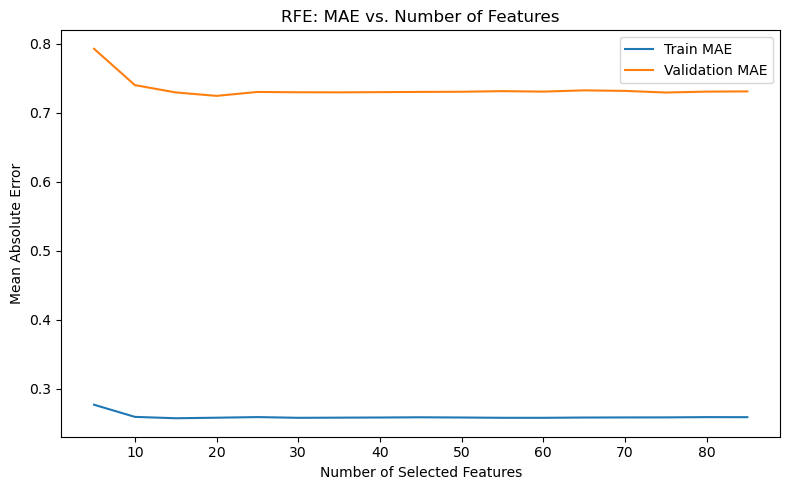

In [240]:
# Use your already scaled and split data:
# X_train, X_val, y_train, y_val

# Because X_train and X_val are numpy arrays (scaled), 
# you need to keep track of feature names separately
feature_names = X_struc.columns  # from your previous cleaning step

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    max_features=None,
    min_samples_split=2,
    random_state=17,
    n_jobs=1
)

n_features_list = list(range(5, X_val.shape[1]+1, 5))
val_errors = []
train_errors = []
selected_features_dict = {}

for n_features in tqdm(n_features_list, desc='RFE Progress'):
    rfe = RFE(estimator=rf, n_features_to_select=n_features, step=5)
    rfe.fit(X_train, y_train)
    
    selected_features = feature_names[rfe.support_].tolist()
    selected_features_dict[n_features] = selected_features
    
    X_train_rfe = rfe.transform(X_train)
    rf.fit(X_train_rfe, y_train)
    
    y_train_pred = rf.predict(X_train_rfe)
    train_errors.append(mean_absolute_error(y_train, y_train_pred))
    
    X_val_rfe = rfe.transform(X_val)
    y_val_pred = rf.predict(X_val_rfe)
    val_errors.append(mean_absolute_error(y_val, y_val_pred))

plt.figure(figsize=(8, 5))
plt.plot(n_features_list, train_errors, label='Train MAE')
plt.plot(n_features_list, val_errors, label='Validation MAE')
plt.xlabel('Number of Selected Features')
plt.ylabel('Mean Absolute Error')
plt.title('RFE: MAE vs. Number of Features')
plt.legend()
plt.tight_layout()
plt.show()


### Only ~20 features needed

Using the following 20 selected features:
['calculation_id', 'icsd_id', 'formationenergy_id', 'duplicate_entry_id', 'volume', 'ntypes', 'natoms', 'delta_e', 'stability', 'ews_0', 'ews_1', 'ews_2', 'ews_3', 'ews_4', 'ews_5', 'ews_6', 'ews_7', 'ews_8', 'ews_10', 'ews_11']
Train MAE: 0.25838104087510555 R²: 0.9492119769890197
Val   MAE: 0.7246384762445205 R²: 0.6039458220420326
Test  MAE: 0.6990785153044793 R²: 0.6108452461006466


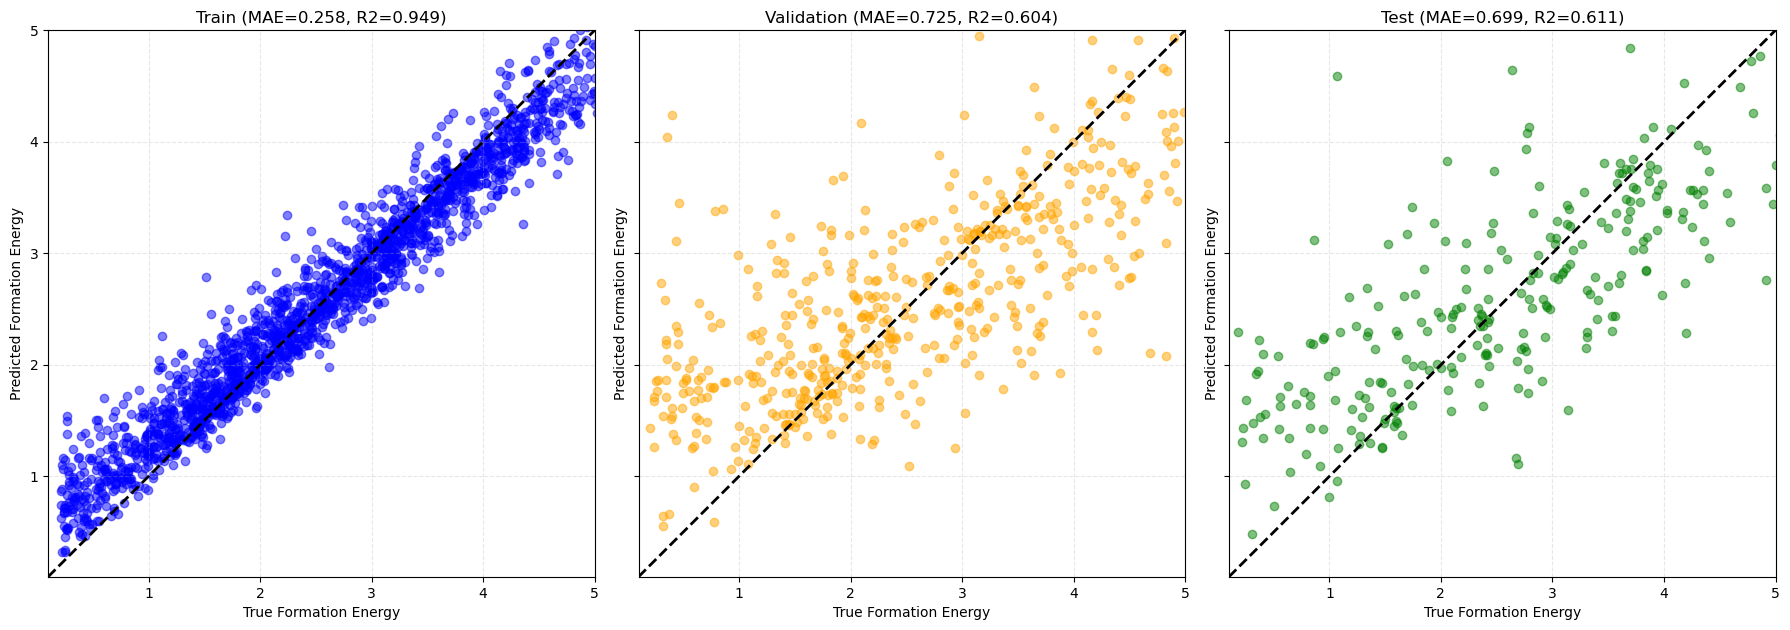

In [241]:
from sklearn.metrics import r2_score, mean_absolute_error

final_features = selected_features_dict[20]   # <-- USE 20 FEATURES

print("Using the following 20 selected features:")
print(final_features)

# BUILD FINAL MODEL
rf_final = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    max_features=None,
    min_samples_split=2,
    random_state=17,
    n_jobs=1
)

# Extract feature columns from scaled numpy arrays
feature_idx = [feature_names.get_loc(f) for f in final_features]

X_train_final = X_train[:, feature_idx]
X_val_final   = X_val[:, feature_idx]
X_test_final  = X_test[:, feature_idx]

#FIT MODEL
rf_final.fit(X_train_final, y_train)

#PREDICTIONS
y_train_pred = rf_final.predict(X_train_final)
y_val_pred   = rf_final.predict(X_val_final)
y_test_pred  = rf_final.predict(X_test_final)

# METRICS
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_val   = mean_absolute_error(y_val, y_val_pred)
mae_test  = mean_absolute_error(y_test, y_test_pred)

r2_train = r2_score(y_train, y_train_pred)
r2_val   = r2_score(y_val, y_val_pred)
r2_test  = r2_score(y_test, y_test_pred)

print("Train MAE:", mae_train, "R²:", r2_train)
print("Val   MAE:", mae_val,   "R²:", r2_val)
print("Test  MAE:", mae_test,  "R²:", r2_test)

# PARITY PLOTS
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

min_val = 0.1
max_val = 5.0

# TRAINING, VALIDATION, TEST
axes[0].scatter(y_train, y_train_pred, alpha=0.5, color='blue')
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[0].set_xlim(min_val, max_val)
axes[0].set_ylim(min_val, max_val)
axes[0].set_title(f"Train (MAE={mae_train:.3f}, R2={r2_train:.3f})")
axes[0].set_xlabel("True Formation Energy")
axes[0].set_ylabel("Predicted Formation Energy")
axes[0].set_aspect('equal', adjustable='box')
axes[0].grid(True, linestyle='--', alpha=0.3)

axes[1].scatter(y_val, y_val_pred, alpha=0.5, color='orange')
axes[1].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[1].set_xlim(min_val, max_val)
axes[1].set_ylim(min_val, max_val)
axes[1].set_title(f"Validation (MAE={mae_val:.3f}, R2={r2_val:.3f})")
axes[1].set_xlabel("True Formation Energy")
axes[1].set_ylabel("Predicted Formation Energy")
axes[1].set_aspect('equal', adjustable='box')
axes[1].grid(True, linestyle='--', alpha=0.3)

axes[2].scatter(y_test, y_test_pred, alpha=0.5, color='green')
axes[2].plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
axes[2].set_xlim(min_val, max_val)
axes[2].set_ylim(min_val, max_val)
axes[2].set_title(f"Test (MAE={mae_test:.3f}, R2={r2_test:.3f})")
axes[2].set_xlabel("True Formation Energy")
axes[2].set_ylabel("Predicted Formation Energy")
axes[2].set_aspect('equal', adjustable='box')
axes[2].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()
